# GraphSAGE

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder

# Load your CSV data
data = pd.read_csv("/content/drive/MyDrive/Brain tumor/Native (T1)/DATA/combined_df.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987 entries, 0 to 986
Columns: 113 entries, diagnostics_Image-original_Mean to Diagnosis
dtypes: float64(110), int64(2), object(1)
memory usage: 871.5+ KB


In [ ]:
le=LabelEncoder()
y=le.fit_transform(data['Diagnosis'])

In [ ]:
# Split data into features (X) and labels (y)
X = data.drop('Diagnosis', axis=1).values
#y = data['Diagnosis'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
y_test

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
import tensorflow as tf

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

In [ ]:
class GraphSAGE(tf.keras.Model):
    def __init__(self, num_classes):
        super(GraphSAGE, self).__init__()
        self.num_classes = num_classes
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense4 = tf.keras.layers.Dense(num_classes, activation='sigmoid')

    def call(self, inputs, training=False):
        x, adj_matrix = inputs
        h = self.dense1(x)
        h = tf.matmul(adj_matrix, h)  # Aggregation step using adjacency matrix
        return self.dense4(h)

# Create the GraphSAGE model
num_classes = 2  # Two classes: 0 and 1
model = GraphSAGE(num_classes)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [ ]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training loop
epochs = 100
for epoch in range(epochs):
    for batch_x, batch_y in train_dataset:
        inputs = (batch_x, tf.linalg.diag(tf.ones(batch_x.shape[0])))  # Identity matrix as adjacency matrix
        loss = train_step(inputs, batch_y)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy()}")

Epoch 1/100, Loss: 0.5410115718841553
Epoch 2/100, Loss: 0.3256111145019531
Epoch 3/100, Loss: 0.23062779009342194
Epoch 4/100, Loss: 0.17971526086330414
Epoch 5/100, Loss: 0.15022392570972443
Epoch 6/100, Loss: 0.13104549050331116
Epoch 7/100, Loss: 0.11733347922563553
Epoch 8/100, Loss: 0.106781005859375
Epoch 9/100, Loss: 0.09892396628856659
Epoch 10/100, Loss: 0.09248674660921097
Epoch 11/100, Loss: 0.08739227056503296
Epoch 12/100, Loss: 0.08296307921409607
Epoch 13/100, Loss: 0.07910321652889252
Epoch 14/100, Loss: 0.07557129859924316
Epoch 15/100, Loss: 0.0724857896566391
Epoch 16/100, Loss: 0.06927957385778427
Epoch 17/100, Loss: 0.06632016599178314
Epoch 18/100, Loss: 0.06346733123064041
Epoch 19/100, Loss: 0.06110166385769844
Epoch 20/100, Loss: 0.05860111862421036
Epoch 21/100, Loss: 0.05673892796039581
Epoch 22/100, Loss: 0.05477268248796463
Epoch 23/100, Loss: 0.05285940319299698
Epoch 24/100, Loss: 0.0507686473429203
Epoch 25/100, Loss: 0.049308981746435165
Epoch 26/100, 

In [ ]:
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
for batch_x, batch_y in test_dataset:
    inputs = (batch_x, tf.linalg.diag(tf.ones(batch_x.shape[0])))
    predictions = model(inputs, training=False)
    test_accuracy(batch_y, predictions)

print(f'Test Accuracy: {test_accuracy.result()}')

Test Accuracy: 0.9848484992980957


In [ ]:
y_pred = []
for batch_x, _ in test_dataset:
    inputs = (batch_x, tf.linalg.diag(tf.ones(batch_x.shape[0])))
    predictions = model(inputs, training=False)
    y_pred.extend(predictions.numpy().argmax(axis=1))

y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.9848484848484849
Confusion Matrix:
[[145   0]
 [  3  50]]


In [ ]:
model.summary()

Model: "graph_sage_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             multiple                  3616      
                                                                 
 dense_3 (Dense)             multiple                  66        
                                                                 
Total params: 3682 (14.38 KB)
Trainable params: 3682 (14.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# GNN



In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=d30864432dd9aee1af0bab0c474de92d989055e85e7e61e5e4fcc509bbb44ff9
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [ ]:
import pandas as pd

data = {
    'Age': [23, 22, 20, 12, 20],
    'tumor_mean': [0.34, 2.34, 0.34, 0.04, 2.10],
    'Tumor_area': [2, 3, 1, 1, 2],
    'Class': [1, 1, 0, 0, 1]
}

df = pd.DataFrame(data)

print(df)

   Age  tumor_mean  Tumor_area  Class
0   23        0.34           2      1
1   22        2.34           3      1
2   20        0.34           1      0
3   12        0.04           1      0
4   20        2.10           2      1


In [ ]:
# Create a graph
G = nx.Graph()

# Add nodes with features
for i, row in df.iterrows():
    G.add_node(i, **row[['Age', 'tumor_mean', 'Tumor_area']].to_dict())

In [ ]:
# Connect nodes based on age difference
age_threshold = 2
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        if abs(df['Age'][i] - df['Age'][j]) <= age_threshold:
            G.add_edge(i, j)

Text(0.5, 1.0, 'Graph with Nodes and Edges')

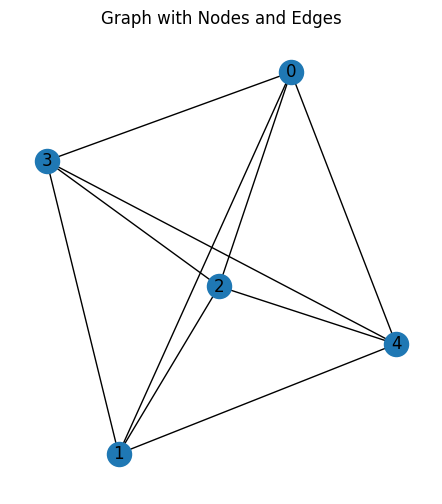

In [ ]:
# Step 2: Visualize the Graphs
plt.figure(figsize=(12, 6))
plt.subplot(121)
nx.draw(G, with_labels=True)
plt.title('Graph with Nodes and Edges')

In [ ]:
class SimpleGCN(nn.Module):
    def __init__(self):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
# Dummy target labels
target_labels = df['Class'].values

In [ ]:
# Split data into training and testing sets
train_idx, test_idx = train_test_split(range(len(df)), test_size=0.2, random_state=42)
x = torch.tensor(df[['Age', 'tumor_mean', 'Tumor_area']].values, dtype=torch.float32)
y = torch.tensor(target_labels, dtype=torch.long)
edge_index = torch.tensor(list(G.edges)).t().contiguous()

In [ ]:
# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)

In [ ]:
data

Data(x=[5, 3], edge_index=[2, 10], y=[5])

In [ ]:
# Initialize and train the GNN model
model = SimpleGCN()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    pred = model(data).argmax(dim=1)
    accuracy = (pred[test_idx] == y[test_idx]).sum().item() / len(test_idx)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 0.00%


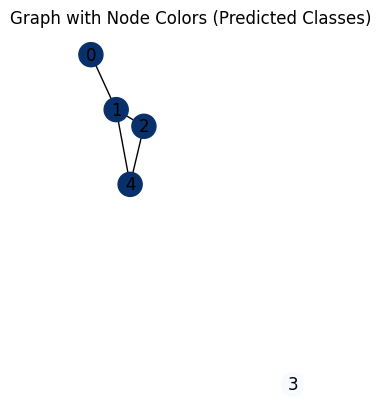

In [ ]:
# Show the plot
plt.subplot(122)
nx.draw(G, with_labels=True, node_color=pred, cmap=plt.cm.Blues)
plt.title('Graph with Node Colors (Predicted Classes)')
plt.show()

# GNN 2

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Brain tumor/Native (T1)/DATA/combined_df.csv")
df.head(4)

,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Diagnosis
0,63.008830,0.0,1043.0,27189,115,0.739545,0.687078,30.967202,45.070872,57.428216,...,0.011435,6.144567,0.018463,1.617553e+05,2.252882,0.000957,104.094198,0.005879,0.365346,HGG
1,42.644644,0.0,726.0,45839,108,0.712809,0.693697,39.632601,57.132479,64.884513,...,0.054986,5.252435,0.008486,1.872055e+06,73.989228,0.000336,9.003672,0.004367,0.019459,HGG
2,46.487673,0.0,594.0,34343,85,0.878777,0.533268,35.224154,66.053440,65.795137,...,0.032918,6.067100,0.019917,2.249511e+05,5.781757,0.000646,33.321381,0.005766,0.117617,HGG
3,63.166312,0.0,1042.0,413,18,0.770522,0.445620,8.942993,20.068633,25.553865,...,0.052850,4.426734,0.087167,9.805270e+02,0.959756,0.034447,3.630403,0.015182,0.580946,HGG


In [ ]:
df['Diagnosis'] = df['Diagnosis'].replace({'HGG': 1, 'LGG': 0})
df.head(4)

,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Diagnosis
0,63.008830,0.0,1043.0,27189,115,0.739545,0.687078,30.967202,45.070872,57.428216,...,0.011435,6.144567,0.018463,1.617553e+05,2.252882,0.000957,104.094198,0.005879,0.365346,1
1,42.644644,0.0,726.0,45839,108,0.712809,0.693697,39.632601,57.132479,64.884513,...,0.054986,5.252435,0.008486,1.872055e+06,73.989228,0.000336,9.003672,0.004367,0.019459,1
2,46.487673,0.0,594.0,34343,85,0.878777,0.533268,35.224154,66.053440,65.795137,...,0.032918,6.067100,0.019917,2.249511e+05,5.781757,0.000646,33.321381,0.005766,0.117617,1
3,63.166312,0.0,1042.0,413,18,0.770522,0.445620,8.942993,20.068633,25.553865,...,0.052850,4.426734,0.087167,9.805270e+02,0.959756,0.034447,3.630403,0.015182,0.580946,1


In [ ]:
df = df[['Diagnosis'] + [col for col in df if col != 'Diagnosis']]
df.head(4)

,Diagnosis,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,63.008830,0.0,1043.0,27189,115,0.739545,0.687078,30.967202,45.070872,...,99.348922,0.011435,6.144567,0.018463,1.617553e+05,2.252882,0.000957,104.094198,0.005879,0.365346
1,1,42.644644,0.0,726.0,45839,108,0.712809,0.693697,39.632601,57.132479,...,9.044773,0.054986,5.252435,0.008486,1.872055e+06,73.989228,0.000336,9.003672,0.004367,0.019459
2,1,46.487673,0.0,594.0,34343,85,0.878777,0.533268,35.224154,66.053440,...,46.742759,0.032918,6.067100,0.019917,2.249511e+05,5.781757,0.000646,33.321381,0.005766,0.117617
3,1,63.166312,0.0,1042.0,413,18,0.770522,0.445620,8.942993,20.068633,...,6.207240,0.052850,4.426734,0.087167,9.805270e+02,0.959756,0.034447,3.630403,0.015182,0.580946


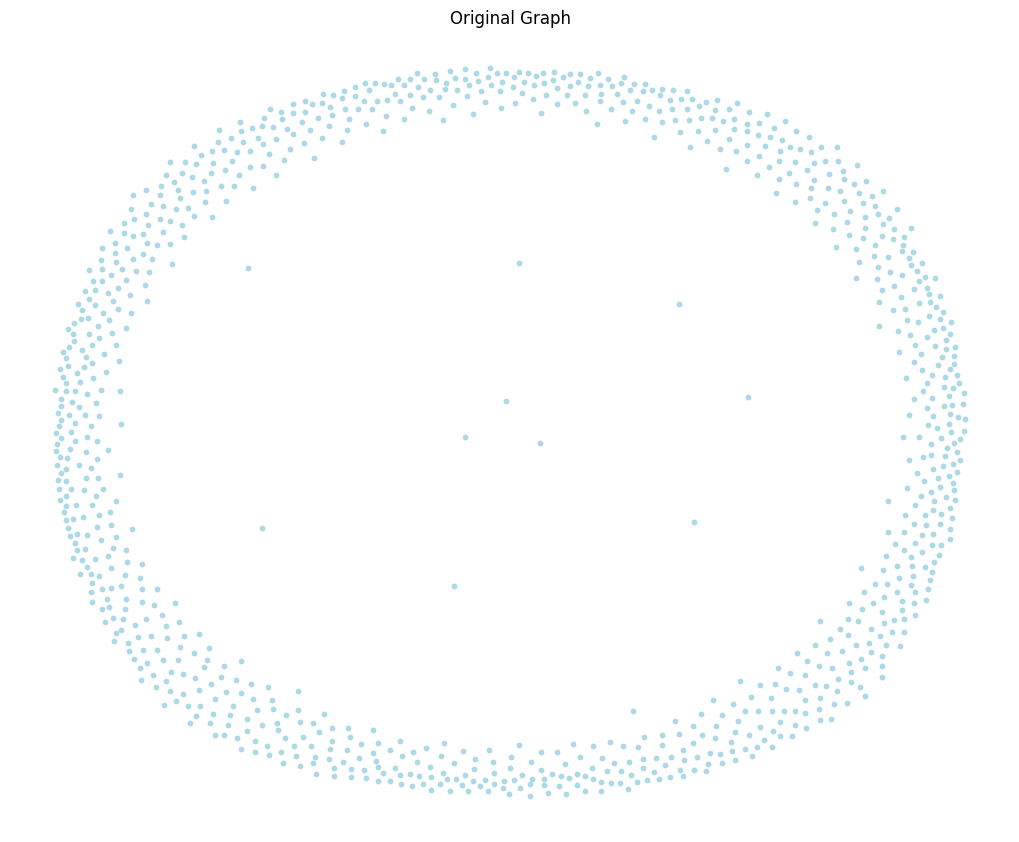

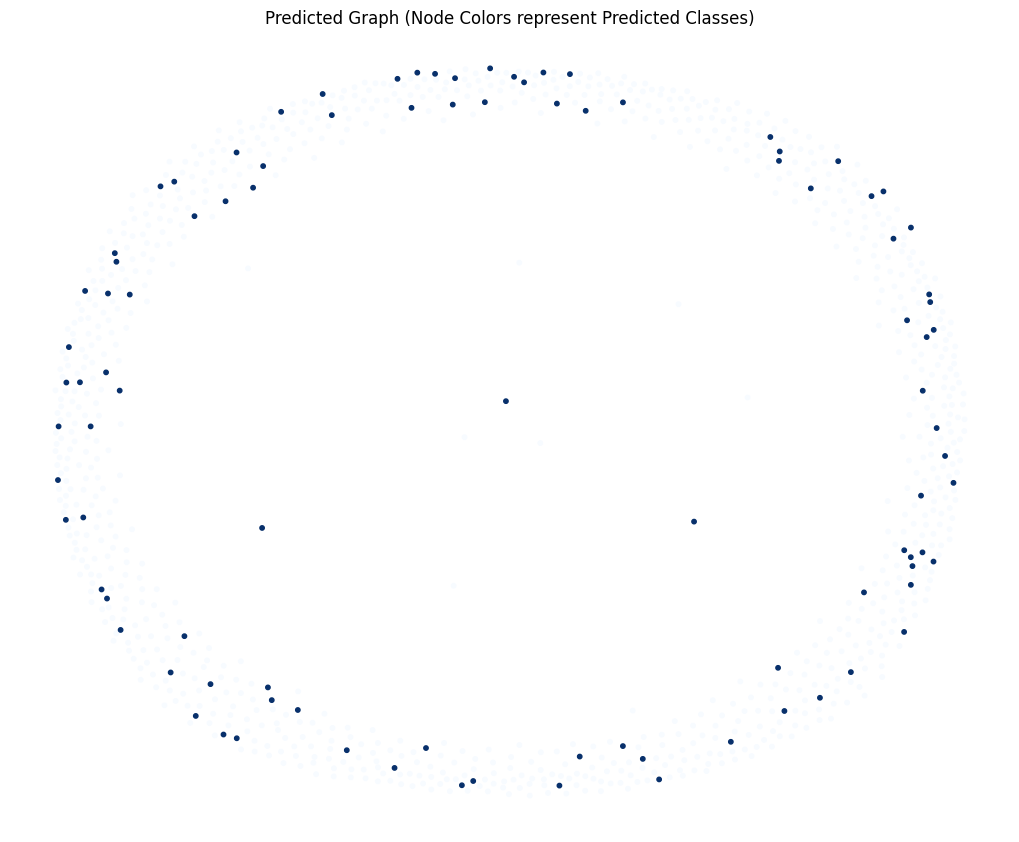

SimpleGCN(
  (conv1): GCNConv(112, 16)
  (conv2): GCNConv(16, 2)
)
Data(x=[987, 112], edge_index=[2, 986], y=[987])
Graph Data Type:  <class 'torch_geometric.data.data.Data'>
Graph Type:  <class 'networkx.classes.graph.Graph'>


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import confusion_matrix, classification_report

# Load your data into df (assuming you have the DataFrame)

# Assume you have df with columns 'Diagnosis', 'feature1', 'feature2', ..., 'feature112'

# Step 1: Convert Tabular Data to Graph Data
# For simplicity, let's create a graph where each row in the DataFrame is a node and connections are based on features

# Create a graph
G = nx.Graph()

# Add nodes with features
for i, row in df.iterrows():
    # Add a node for each row with features as attributes
    G.add_node(i, **row[1:].to_dict())  # Assuming features start from the second column

# Step 2: Visualize the Graph (Note: This may not be practical for large graphs)
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='lightblue', with_labels=False, node_size=10)
plt.title('Original Graph')
plt.show()

# Step 3: Build a GNN Model
class SimpleGCN(nn.Module):
    def __init__(self):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(112, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Dummy target labels
target_labels = df['Diagnosis'].values

# Dummy edge connections (connecting nodes in a chain)
edge_index = torch.tensor([(i, i+1) for i in range(len(df)-1)], dtype=torch.long).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(x=torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32), edge_index=edge_index, y=torch.tensor(target_labels, dtype=torch.long))

# Initialize and train the GNN model
model = SimpleGCN()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    pred = model(data).argmax(dim=1)

# Calculate metrics
conf_matrix = confusion_matrix(data.y, pred)
class_report = classification_report(data.y, pred)

# Step 4: Visualize Predictions
plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=pred, cmap=plt.cm.Blues, with_labels=False, node_size=10)
plt.title('Predicted Graph (Node Colors represent Predicted Classes)')
plt.show()

# Print model summary and graph information
print(model)
print(data)
print("Graph Data Type: ", type(data))
print("Graph Type: ", type(G))

In [ ]:
# Create a graph
G = nx.Graph()

# Add nodes with features
for i, row in df.iterrows():
    # Add a node for each row with features as attributes
    G.add_node(i, **row[1:].to_dict())  # Assuming features start from the second column

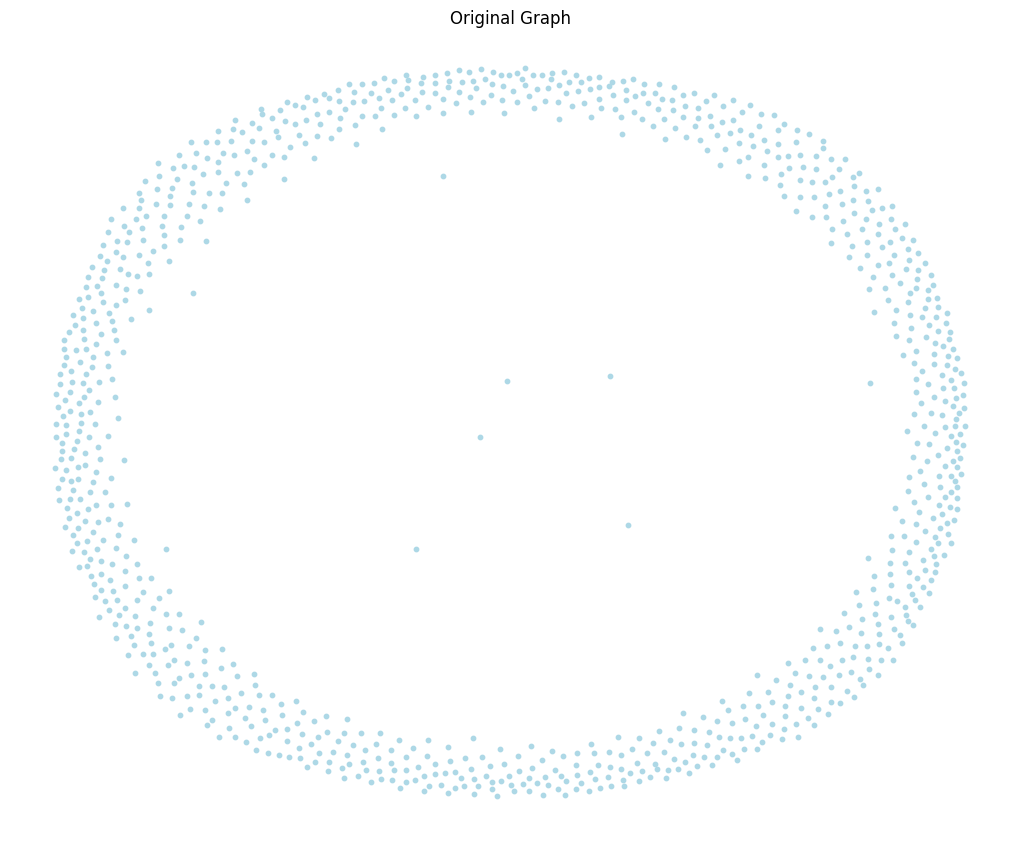

In [ ]:
# Step 2: Visualize the Graph (Note: This may not be practical for large graphs)
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='lightblue', with_labels=False, node_size=10)
plt.title('Original Graph')
plt.show()

In [ ]:
# Step 3: Build a GNN Model
class SimpleGCN(nn.Module):
    def __init__(self):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(112, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
# Dummy target labels
target_labels = df['Diagnosis'].values

# Dummy edge connections (connecting nodes in a chain)
edge_index = torch.tensor([(i, i+1) for i in range(len(df)-1)], dtype=torch.long).t().contiguous()

# Create PyTorch Geometric Data object
data = Data(x=torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32), edge_index=edge_index, y=torch.tensor(target_labels, dtype=torch.long))

In [ ]:
# Initialize and train the GNN model
model = SimpleGCN()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{100}, Loss: {loss.item()}')

Epoch 1/100, Loss: 892640640.0
Epoch 2/100, Loss: 154947600.0
Epoch 3/100, Loss: 326270784.0
Epoch 4/100, Loss: 403619776.0
Epoch 5/100, Loss: 422778144.0
Epoch 6/100, Loss: 402942048.0
Epoch 7/100, Loss: 353638080.0
Epoch 8/100, Loss: 281264928.0
Epoch 9/100, Loss: 190328064.0
Epoch 10/100, Loss: 84056656.0
Epoch 11/100, Loss: 153761472.0
Epoch 12/100, Loss: 114822096.0
Epoch 13/100, Loss: 57607028.0
Epoch 14/100, Loss: 114683648.0
Epoch 15/100, Loss: 148366560.0
Epoch 16/100, Loss: 161555712.0
Epoch 17/100, Loss: 156662544.0
Epoch 18/100, Loss: 135719904.0
Epoch 19/100, Loss: 100451480.0
Epoch 20/100, Loss: 52316584.0
Epoch 21/100, Loss: 30206912.0
Epoch 22/100, Loss: 9731233.0
Epoch 23/100, Loss: 10686328.0
Epoch 24/100, Loss: 10652669.0
Epoch 25/100, Loss: 46374260.0
Epoch 26/100, Loss: 77078160.0
Epoch 27/100, Loss: 90897272.0
Epoch 28/100, Loss: 89449880.0
Epoch 29/100, Loss: 74149952.0
Epoch 30/100, Loss: 46248496.0
Epoch 31/100, Loss: 7418268.0
Epoch 32/100, Loss: 181057024.0
E

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    pred = model(data).argmax(dim=1)

In [ ]:
# Calculate metrics
conf_matrix = confusion_matrix(data.y, pred)
conf_matrix

array([[196,  31],
       [712,  48]])

In [ ]:
class_report = classification_report(data.y, pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.22      0.86      0.35       227
           1       0.61      0.06      0.11       760

    accuracy                           0.25       987
   macro avg       0.41      0.46      0.23       987
weighted avg       0.52      0.25      0.17       987



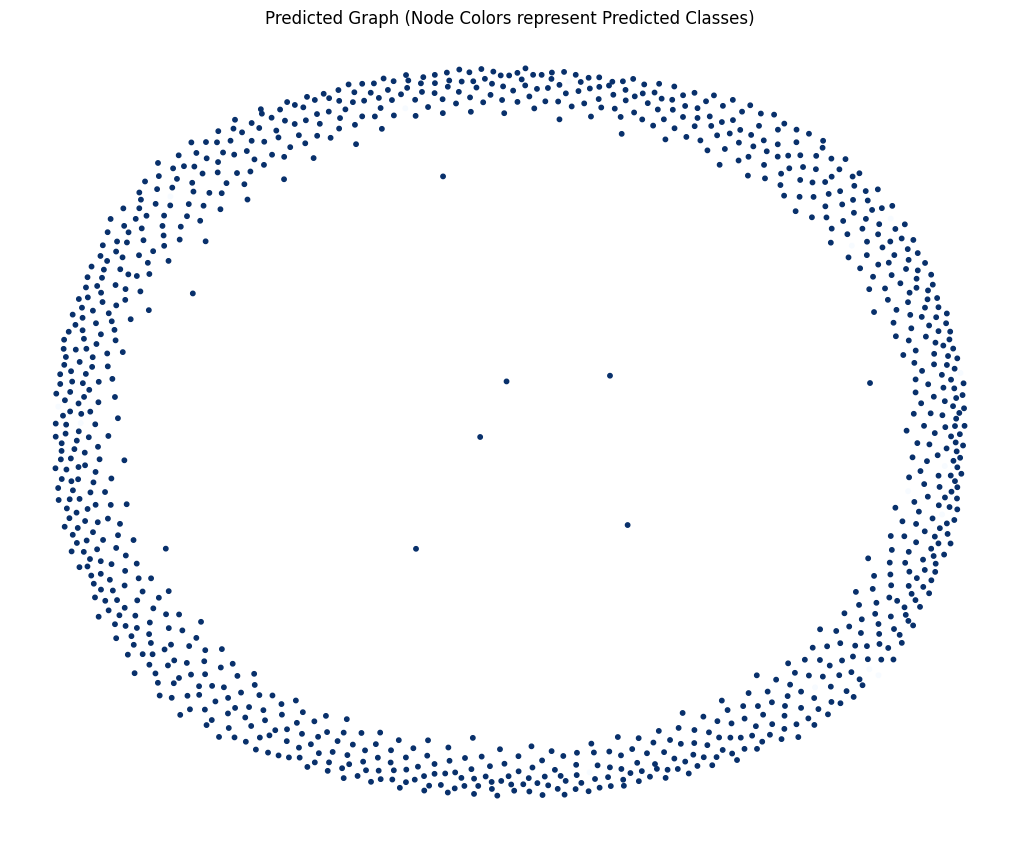

In [ ]:
# Step 4: Visualize Predictions
plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=pred, cmap=plt.cm.Blues, with_labels=False, node_size=10)
plt.title('Predicted Graph (Node Colors represent Predicted Classes)')
plt.show()

In [ ]:
# Print model summary and graph information
print(model)
print(data)
print("Graph Data Type: ", type(data))
print("Graph Type: ", type(G))

SimpleGCN(
  (conv1): GCNConv(112, 16)
  (conv2): GCNConv(16, 2)
)
Data(x=[987, 112], edge_index=[2, 986], y=[987])
Graph Data Type:  <class 'torch_geometric.data.data.Data'>
Graph Type:  <class 'networkx.classes.graph.Graph'>
